#**HW5: Image Classification & Detection**
*CS4610/5335: Robotic Science and Systems (Spring 2023) | Robert Platt | Northeastern University*

--------------------------

Please remember the following policies:
- Submissions should be made electronically via the Canvas. For this assignment, you should submit both a *.ipynb and *.pdf version of your completed Colab notebook as a single zipped file.
- You are welcome to discuss the programming questions (but not the written questions) with other students in the class. However, you must understand and write all code yourself. Also, you must list all students (if any)
with whom you discussed your solutions to the programming questions.
- Please provide comments in your code to make it understandable to the graders. 

Collaborators: [*Optional*]

In [1]:
%%capture
! pip install pytorch-lightning

In [2]:
## UPLOAD utils.py: click "Choose Files" then click on "utils.py"
from google.colab import files
uploaded = files.upload()

try:
  import utils
except ModuleNotFoundError:
  raise ModuleNotFoundError(
    'ERROR: you did not upload "utils.py" correctly, run the cell again.'
  )

Saving utils.py to utils.py


In [3]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Q1a. Implementing AlexNet
In this question, you will implement AlexNet in PyTorch using the model achitecture diagram provided below. 
For an introduction to creating neural networks with PyTorch, see this [guide](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#model-layers).  If you want to look up specific pytorch modules, try searching the [docs](https://pytorch.org/docs/stable/index.html).


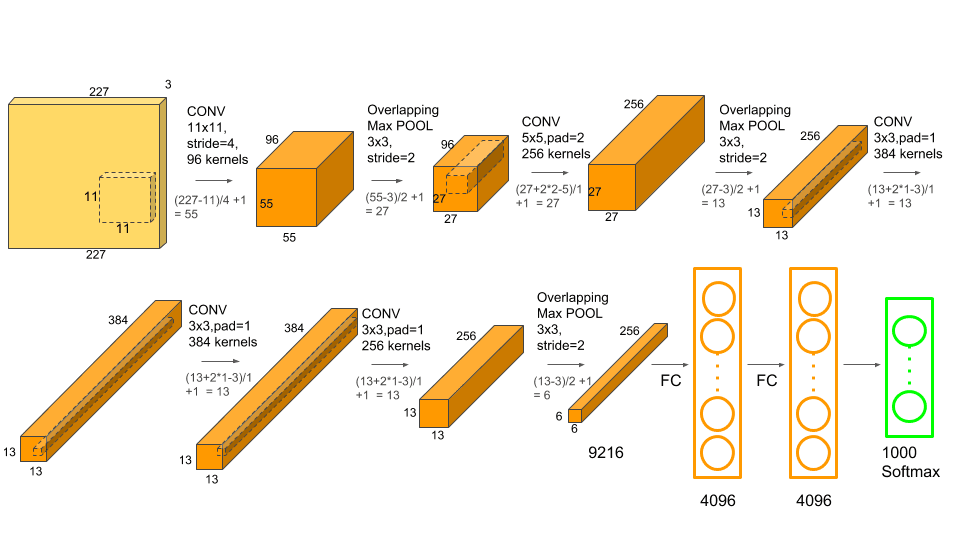

In [ ]:
class AlexNet(nn.Module):
  def __init__(self):
    """
    You need to add ReLU activations after every internal convolution or linear layer.
    Do not add BatchNorm layers
    """
    super().__init__()

    # define your layers here, the first operation is done for you
    # you may use nn.Sequential if you wish
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4)
    self.relu = nn.ReLU(True)
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
    # ...
    
  def forward(self, x): 
    """Performs forward pass

    Arguments
    ---------
    x: Tensor
      image tensor of shape (B, 3, 227, 227)
    
    Returns
    -------
    Tensor
      logits (ranging from 0 to 1) tensor with shape (B, 1000)
    """
    pass


# To help you debug, you may want to print the shapes of tensors
# produced after each layer in the network
model = AlexNet()
img = torch.randn((1, 3, 227, 227), dtype=torch.float32)
model(img)

utils.check_q1a(AlexNet())

# Q1b. Customizing AlexNet for Smaller Images
The original AlexNet was designed for 227x227 images.  Modify the network to handle 37x37 images while keeping the model parameters constant.  In other words, do not change the channel dimensions or kernel sizes.  Instead modify the convolution padding or stride or remove maxpool operations.  


In [ ]:
class SmallAlexNet(nn.Module):
  def __init__(self):
    '''
    You need to add ReLU activations after every internal convolution or linear layer.
    Do not add BatchNorm layers

    Hint
    ----
    You want the feature map produced by the final conv layer to be 6x6 
    '''
    super().__init__()
    pass
    
  def forward(self, x): 
    """Performs forward pass

    Arguments
    ---------
    x: Tensor
      image tensor of shape (B, 3, 37, 37)
    
    Returns
    -------
    Tensor
      logits (ranging from 0 to 1) tensor with shape (B, 1000)
    """
    pass

utils.check_q1b(SmallAlexNet())

# Q2. Implementing Basic Block
One of the most common network architectures for computer vision is the Residual Network (ResNet), first introduced by [He et al. (2015)](https://arxiv.org/abs/1512.03385).  ResNets are constructed by stacking many residual blocks in a row.  In this problem, you will implement the BasicBlock, which is used in the ResNet18 and ResNet34 networks. 

In [ ]:
class BasicBlock(nn.Module):
  def __init__(self, c_in: int, c_out: int, stride):
    """
    x -> conv3x3(c_in, c_out, stride) -> bn -> relu -> conv3x3(c_out, c_out) -> bn -> + -> relu -> out
    |                                                                                 ^
    '------------------> conv1x1(c_in, c_out, stride) -> bn --------------------------'
    """
    pass

  def forward(self, x: Tensor) -> Tensor:
    pass

Why are residual connections beneficial when designing deep networks?

*\[answer here\]*

Why is there a conv1x1 layer in the residual pathway? What purpose does it serve?  Hint: see what happens when it is removed.

*\[answer here\]*

# Q3. Fine Tuning on Smaller Dataset
You are given [MobileNetV2](https://arxiv.org/abs/1801.04381) pretrained on ImageNet and need to modify it so that it can train on a smaller dataset of [flowers](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/).  To do this, you need to switch the network head to a linear layer with the proper output dimension, in this case 102 classes.  Then you need to configure the optimizer
to apply gradient descent on the head.

In [ ]:
class MobileNetV2_finetune(pl.LightningModule):
  def __init__(self):
    super().__init__()
    pretrained_model = torchvision.models.mobilenet_v2(
        weights=torchvision.models.MobileNet_V2_Weights
    )
    # MODIFY MODEL HEAD 
    pass

  def forward(self, x):
    """Performs forward pass

    Arguments
    ---------
    x: Tensor
      image tensor of shape (B, 3, 128, 128)
    
    Returns
    -------
    Tensor
      logits (ranging from 0 to 1) tensor with shape (B, 102)
    """
    # MAKE SURE TO PERFORM SOFTMAX on output
    pass

  def configure_optimizers(self):
    # FIX THIS SO IT ONLY OPTIMIZES CERTAIN PARAMETERS
    trainable_params = self.parameters()
    optimizer = torch.optim.Adam(trainable_params, lr=1e-3)
    return optimizer
    
  def training_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self(x)
    loss = nn.functional.nll_loss(y_pred, y)
    acc = (torch.argmax(y_pred, 1) == y).float().mean()
    self.log("train_acc", acc, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_pred = self(x)
    loss = nn.functional.nll_loss(y_pred, y)
    acc = (torch.argmax(y_pred, 1) == y).float().mean()
    self.log("val_acc", acc, prog_bar=True)
    return loss


model = MobileNetV2_finetune()
pl.seed_everything(42, workers=True)
train_dl, val_dl = utils.get_flowers_dataloaders(batch_size=512)
trainer = pl.Trainer(max_epochs=20, accelerator='gpu')
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

# this may take about 5 min to run
# you should achieve a validation accuracy of ~0.68 if done correctly

# Q4. Data Augmentation to Improve Generalization
This is good but I bet we can do better.  Try out some data augmentations and see what performance you can get (see full list of supported transforms [here](https://pytorch.org/vision/0.11/transforms.html)).  For two different transformations (or compositions of transformations), explain why you believe this transformation could improve generalization and what validation accuracy you achieve (it's okay if it does not improve performance).

1.   *\[transformation 1\]*
2.   *\[transformation 2\]*




In [ ]:
# if you want to visualize dataset to think about useful transforms
_, val_dl = utils.get_flowers_dataloaders(batch_size=15)
imgs, _ = next(iter(val_dl))
plt.figure()
grid_img = torchvision.utils.make_grid(imgs, nrow=5, normalize=True).permute((1, 2, 0))
plt.imshow(grid_img)
plt.axis('off')
plt.show()

In [ ]:
# try your first transform here
TRAIN_TFM = ###

model = MobileNetV2_finetune()
pl.seed_everything(42, workers=True)
train_dl, val_dl = utils.get_flowers_dataloaders(batch_size=512, train_tfm=TRAIN_TFM)
trainer = pl.Trainer(max_epochs=20, accelerator='gpu')
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

In [ ]:
# try your second transform here
TRAIN_TFM = ###

model = MobileNetV2_finetune()
pl.seed_everything(42, workers=True)
train_dl, val_dl = utils.get_flowers_dataloaders(batch_size=512, train_tfm=TRAIN_TFM)
trainer = pl.Trainer(max_epochs=20, accelerator='gpu')
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

# Q5. Segmentation with UNet-style Architecture
Implement a UNet-style network as specified in the diagram below.  Place a BatchNorm and ReLU after every conv or convtranspose layer.
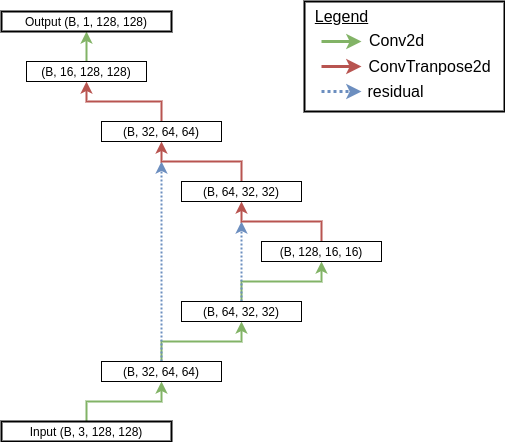

In [ ]:
class UNet(utils.SegmentationModule):
  def __init__(self):
    super().__init__()

    # IMPLEMENT LAYERS HERE
    pass
    
  def forward(self, x):
    '''
    Arguments
    ---------
    x : Tensor
      image tensor of shape (B, 3, 128, 128)

    Returns
    -------
    Tensor
      image tensor of shape (B, 1, 128, 128) where every pixel is within (0,1)
      and describes the probability that the pixel is in the foreground
    '''
    pass


# run this cell to debug the model using a dummy input
model = UNet()
dummy_input = torch.randn((30, 3, 128, 128), dtype=torch.float32)
output = model(dummy_input)

# MAKE SURE OUTPUT IMAGE HAS SAME HEIGHT AND WIDTH AS INPUT
assert output.shape[2:] == dummy_input.shape[2:]

# MAKE SURE THE OUTPUT IMAGE PIXELS VARY FROM 0 to 1
assert output.min().item() > 0 and output.max().item() < 1

In [ ]:
# Train model once you have debugged the forward pass
train_dl, val_dl = utils.get_voc_dataloaders(batch_size=256)

model = UNet()
pl.seed_everything(42, workers=True)
trainer = pl.Trainer(max_epochs=10, accelerator='gpu',
                     logger=pl.loggers.TensorBoardLogger('./voc'),
                     log_every_n_steps=1)
                      

# this will take about 8 minutes
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

Why is it useful to perform downsampling then upsampling within the network? Think about how information is processed within the network.

*\[answer here\]*

Run the code cell below to view TensorBoard.  Look at the plots of the train and validation losses.  Is model overfitting here?  Explain why you think it is or is not.
*\[answer here\]*

In [ ]:
%load_ext tensorboard
%tensorboard --logdir voc/lightning_logs
# it make take a few seconds to load